### LASSO parameter range experiments

We want to see whether smaller models (i.e. models with fewer nonzero features) tend to generalize to new cancer types better than larger ones; this script compares/visualizes those results.

In [1]:
import os
import itertools as it

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import seaborn as sns

import pancancer_evaluation.config as cfg
import pancancer_evaluation.utilities.data_utilities as du
import pancancer_evaluation.utilities.analysis_utilities as au

%load_ext autoreload
%autoreload 2

In [2]:
base_results_dir = os.path.join(
    cfg.repo_root, '02_cancer_type_classification', 'results', 'lasso_range_valid'
)

training_dataset = 'all_other_cancers'
results_dir = os.path.join(base_results_dir, training_dataset)

plot_gene = 'TP53'
metric = 'aupr'

### Get coefficient information for each lasso penalty

In [3]:
nz_coefs_df = []

# get pancancer coefs info for now
for coef_info in au.generate_nonzero_coefficients_lasso_range(results_dir):
    (gene,
     cancer_type,
     seed,
     lasso_param,
     coefs_list) = coef_info
    for fold_no, coefs in enumerate(coefs_list):
        nz_coefs_df.append(
            [gene, cancer_type, lasso_param, seed, fold_no, len(coefs)]
        )
        
nz_coefs_df = pd.DataFrame(
    nz_coefs_df,
    columns=['gene', 'cancer_type', 'lasso_param', 'seed', 'fold', 'nz_coefs']
)
nz_coefs_df = nz_coefs_df[nz_coefs_df.gene == plot_gene].copy()
nz_coefs_df.head()

,gene,cancer_type,lasso_param,seed,fold,nz_coefs
0,TP53,UCEC,0.00025,42,0,6882
1,TP53,UCEC,0.00025,42,1,6827
2,TP53,UCEC,0.00025,42,2,6923
3,TP53,UCEC,0.00025,42,3,6898
4,TP53,LUAD,0.0005,1,0,6143


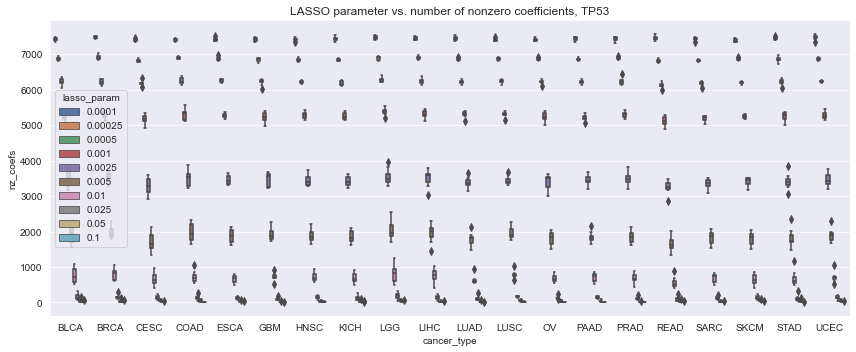

In [4]:
genes = ['TP53']

sns.set({'figure.figsize': (12, 5)})

sns.boxplot(
    data=nz_coefs_df.sort_values(by=['cancer_type', 'lasso_param']),
    x='cancer_type', y='nz_coefs', hue='lasso_param'
)
plt.title(f'LASSO parameter vs. number of nonzero coefficients, {plot_gene}')
plt.tight_layout()

### Get performance information for each lasso penalty

In [5]:
perf_df = au.load_prediction_results_lasso_range(results_dir, training_dataset)
perf_df = perf_df[perf_df.gene == plot_gene].copy()
perf_df.head()

,auroc,aupr,gene,holdout_cancer_type,signal,seed,data_type,fold,experiment,lasso_param
0,0.661710,0.63834,TP53,OV,signal,42,train,0,all_other_cancers,0.1
1,0.089431,0.84457,TP53,OV,signal,42,test,0,all_other_cancers,0.1
2,0.668130,0.60945,TP53,OV,signal,42,cv,0,all_other_cancers,0.1
3,0.685860,0.62514,TP53,OV,signal,42,train,1,all_other_cancers,0.1
4,0.666670,0.97639,TP53,OV,signal,42,test,1,all_other_cancers,0.1


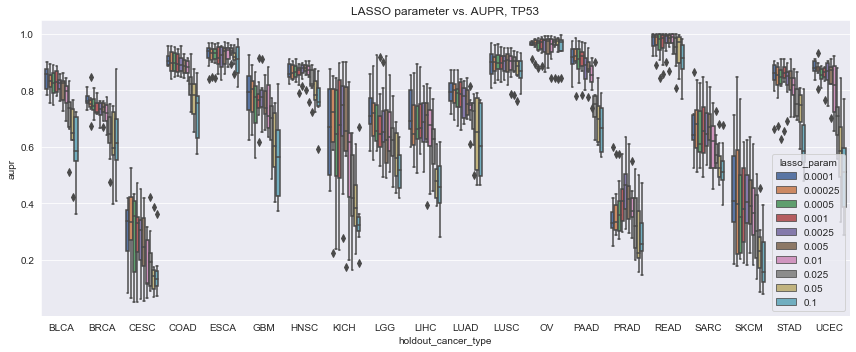

In [6]:
sns.set({'figure.figsize': (12, 5)})

sns.boxplot(
    data=(
        perf_df[(perf_df.signal == 'signal') &
                (perf_df.data_type == 'test')]
          .sort_values(by=['holdout_cancer_type', 'lasso_param'])
    ), x='holdout_cancer_type', y=metric, hue='lasso_param'
)
plt.title(f'LASSO parameter vs. {metric.upper()}, {plot_gene}')
plt.tight_layout()

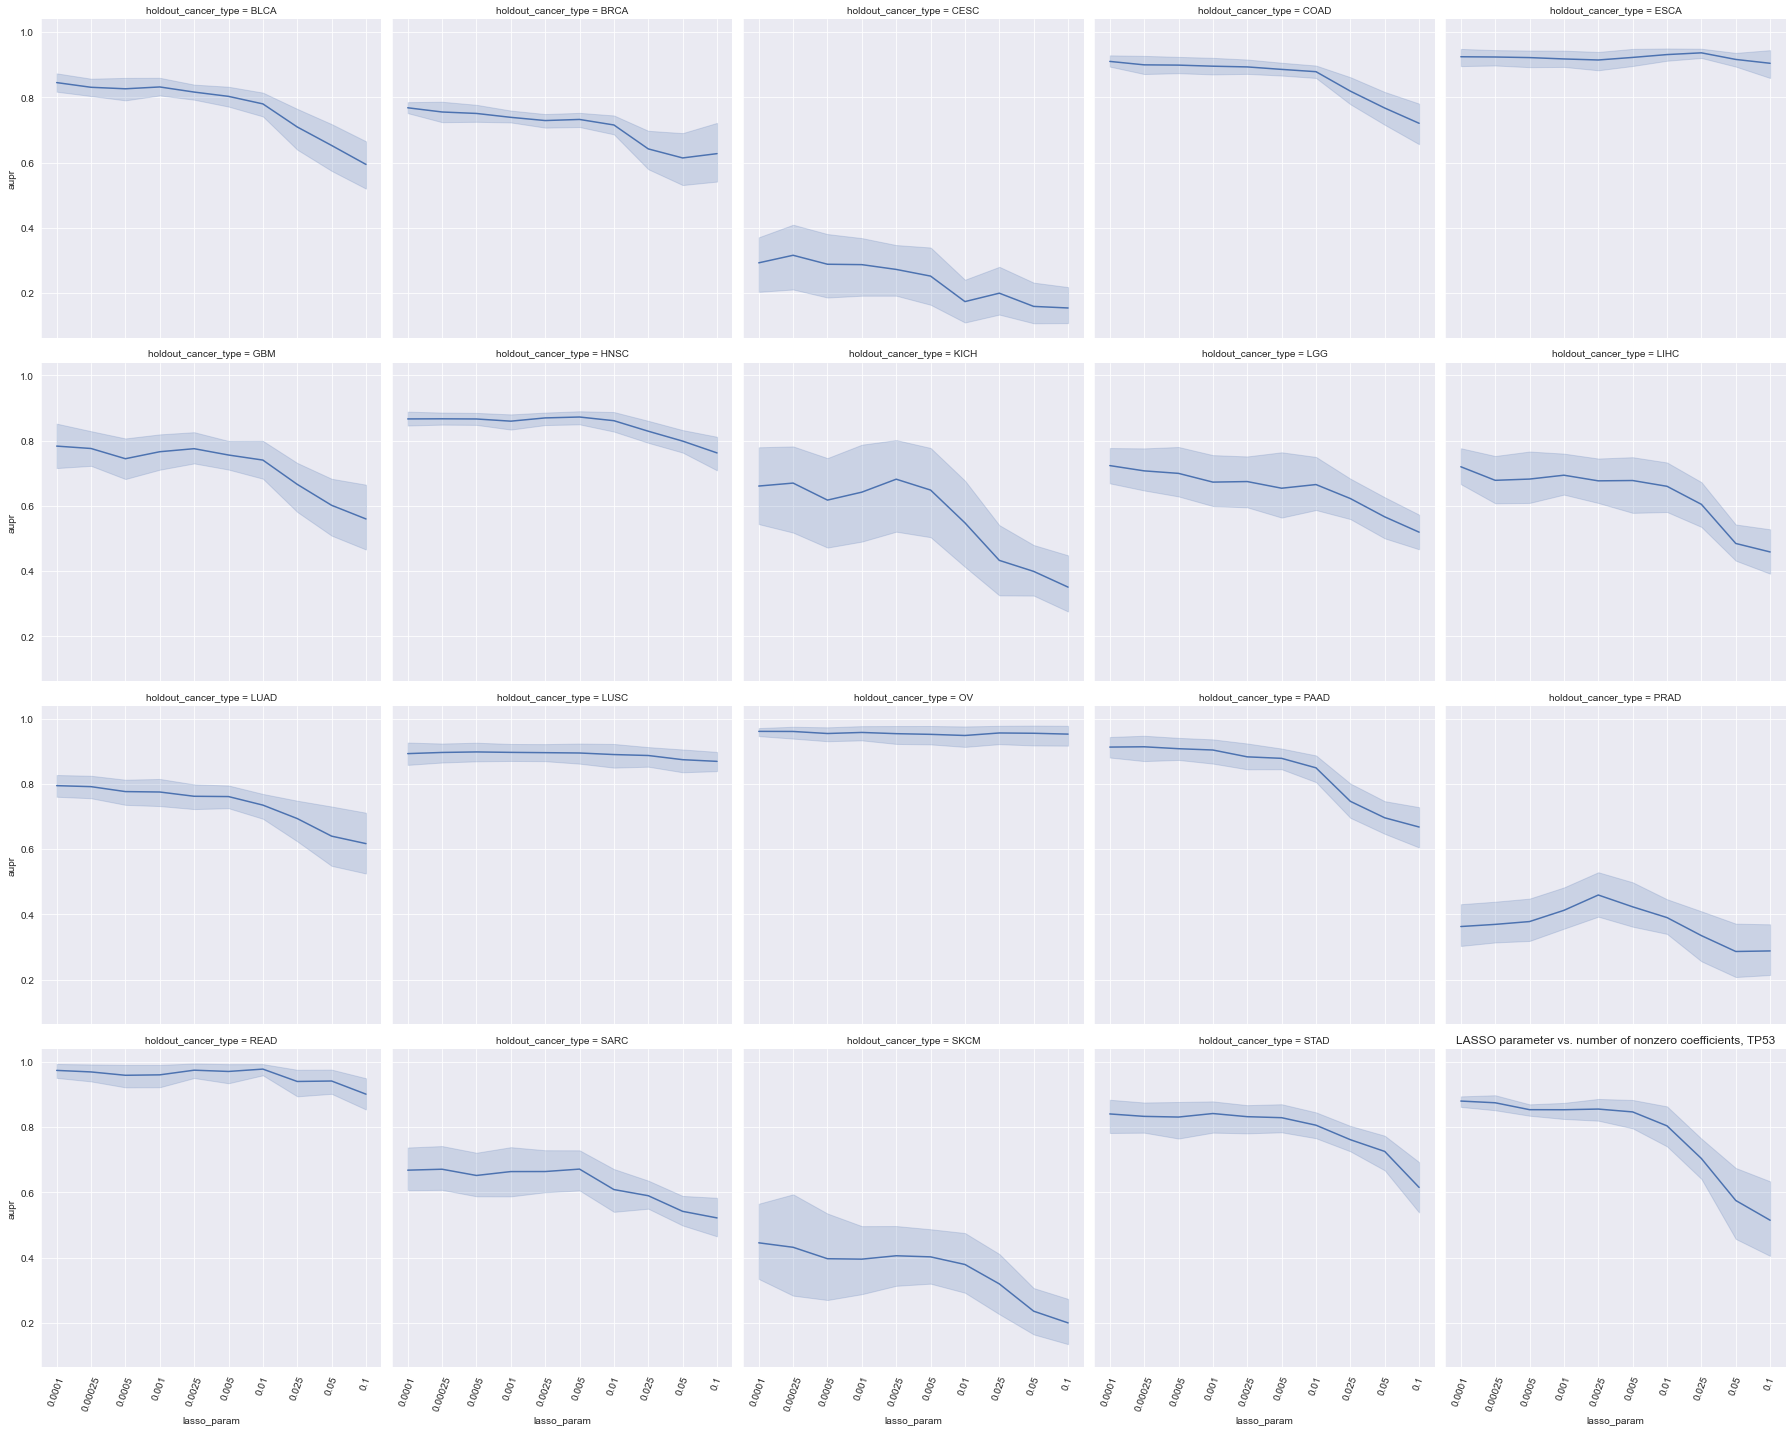

In [7]:
sns.set({'figure.figsize': (12, 5)})

plot_df = (
    perf_df[(perf_df.signal == 'signal') &
            (perf_df.data_type == 'test')]
      .sort_values(by=['holdout_cancer_type', 'lasso_param'])
      .reset_index(drop=True)
)

g = sns.relplot(
    data=plot_df,
    x="lasso_param", y=metric, col="holdout_cancer_type", col_wrap=5,
    kind="line",
)
g.set_xticklabels(rotation=70)
plt.title(f'LASSO parameter vs. number of nonzero coefficients, {plot_gene}')
plt.tight_layout()

### Compare feature selection with performance

In [8]:
coefs_perf_df = (nz_coefs_df
    .rename(columns={'cancer_type': 'holdout_cancer_type'})
    .merge(perf_df[perf_df.signal == 'signal'],
           on=['gene', 'holdout_cancer_type', 'seed', 'fold', 'lasso_param'])
    .drop(columns=['signal'])
)

coefs_perf_df.head()

,gene,holdout_cancer_type,lasso_param,seed,fold,nz_coefs,auroc,aupr,data_type,experiment
0,TP53,UCEC,0.00025,42,0,6882,0.99924,0.99898,train,all_other_cancers
1,TP53,UCEC,0.00025,42,0,6882,0.89719,0.87748,test,all_other_cancers
2,TP53,UCEC,0.00025,42,0,6882,0.87192,0.84983,cv,all_other_cancers
3,TP53,UCEC,0.00025,42,1,6827,0.99875,0.99850,train,all_other_cancers
4,TP53,UCEC,0.00025,42,1,6827,0.89358,0.80434,test,all_other_cancers


Text(0, 0.5, 'Holdout AUPR')

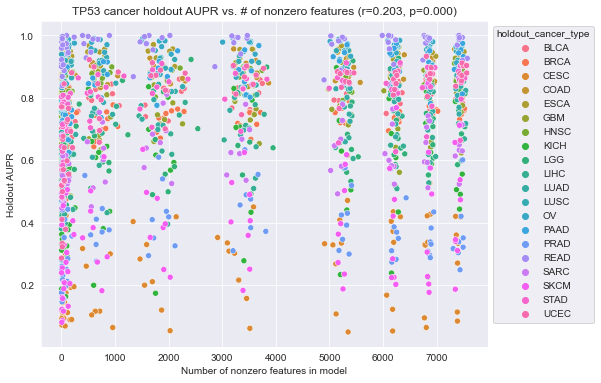

In [9]:
# plot test performance vs. number of nonzero features
sns.set({'figure.figsize': (8, 6)})

plot_df = (
    coefs_perf_df[coefs_perf_df.data_type == 'test']
      .sort_values(by='holdout_cancer_type')
)
r, p = pearsonr(plot_df.nz_coefs.values, plot_df.aupr.values)

ax = sns.scatterplot(data=plot_df, x='nz_coefs', y='aupr', hue='holdout_cancer_type')
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1))
plt.title(f'{plot_gene} cancer holdout AUPR vs. # of nonzero features (r={r:.3f}, p={p:.3f})')
plt.xlabel('Number of nonzero features in model')
plt.ylabel('Holdout AUPR')

In [10]:
coefs_perf_pivot_df = coefs_perf_df.pivot(
    index=['gene', 'holdout_cancer_type', 'seed', 'fold', 'lasso_param', 'nz_coefs'],
    columns='data_type',
    values=['auroc', 'aupr']
)
coefs_perf_pivot_df.columns = ['_'.join(col).strip() for col in coefs_perf_pivot_df.columns.values]
coefs_perf_pivot_df.reset_index(inplace=True)

coefs_perf_pivot_df

,gene,holdout_cancer_type,seed,fold,lasso_param,nz_coefs,auroc_cv,auroc_test,auroc_train,aupr_cv,aupr_test,aupr_train
0,TP53,BLCA,1,0,0.0001,7408,0.89676,0.86038,0.99994,0.87061,0.89194,0.99993
1,TP53,BLCA,1,0,0.00025,6801,0.89678,0.83690,0.99896,0.87151,0.85910,0.99855
2,TP53,BLCA,1,0,0.0005,6134,0.88610,0.85199,0.99713,0.86172,0.88848,0.99586
3,TP53,BLCA,1,0,0.001,5171,0.88728,0.83354,0.99335,0.85330,0.86231,0.99172
4,TP53,BLCA,1,0,0.0025,3291,0.88371,0.84319,0.97671,0.85788,0.83210,0.97061
...,...,...,...,...,...,...,...,...,...,...,...,...
1595,TP53,UCEC,42,3,0.005,1974,0.87775,0.85492,0.95976,0.85305,0.82259,0.94835
1596,TP53,UCEC,42,3,0.01,740,0.86196,0.81780,0.91899,0.83305,0.79351,0.89950
1597,TP53,UCEC,42,3,0.025,116,0.79896,0.76098,0.83432,0.77305,0.73083,0.80666
1598,TP53,UCEC,42,3,0.05,36,0.71137,0.59242,0.75142,0.69862,0.56950,0.73073


Text(0, 0.5, 'Validation AUPR')

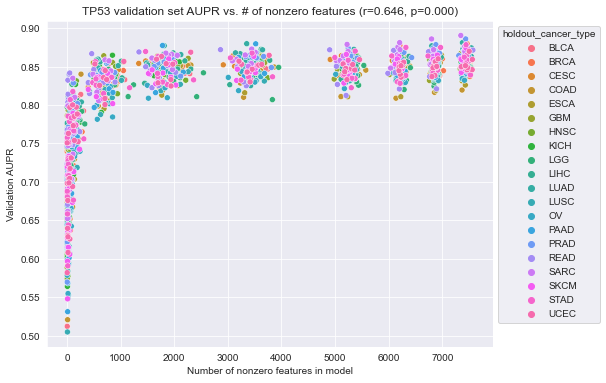

In [11]:
# plot validation performance vs. number of nonzero features
sns.set({'figure.figsize': (8, 6)})
r, p = pearsonr(coefs_perf_pivot_df.nz_coefs.values, coefs_perf_pivot_df.aupr_cv.values)

ax = sns.scatterplot(data=coefs_perf_pivot_df, x='nz_coefs', y='aupr_cv', hue='holdout_cancer_type')
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1))
plt.title(f'{plot_gene} validation set AUPR vs. # of nonzero features (r={r:.3f}, p={p:.3f})')
plt.xlabel('Number of nonzero features in model')
plt.ylabel('Validation AUPR')

Text(0, 0.5, '(Validation AUPR) / (Holdout AUPR)')

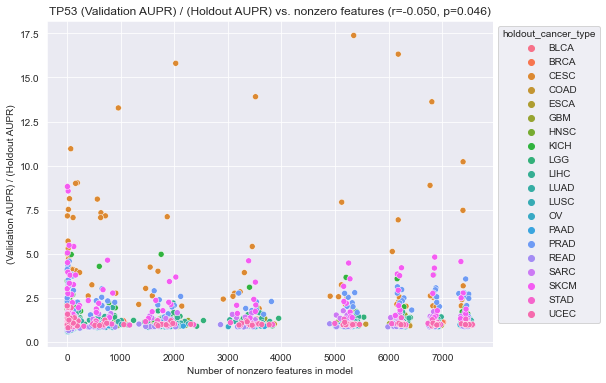

In [12]:
# plot validation performance vs. number of nonzero features
sns.set({'figure.figsize': (8, 6)})

coefs_perf_pivot_df['cv_test_aupr_ratio'] = (
    coefs_perf_pivot_df['aupr_cv']/ coefs_perf_pivot_df['aupr_test']
)
r, p = pearsonr(coefs_perf_pivot_df.nz_coefs.values, coefs_perf_pivot_df.cv_test_aupr_ratio.values)

ax = sns.scatterplot(data=coefs_perf_pivot_df, x='nz_coefs', y='cv_test_aupr_ratio', hue='holdout_cancer_type')
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1))
plt.title(f'{plot_gene} (Validation AUPR) / (Holdout AUPR) vs. nonzero features (r={r:.3f}, p={p:.3f})')
plt.xlabel('Number of nonzero features in model')
plt.ylabel('(Validation AUPR) / (Holdout AUPR)')

For this limited set of genes/cancer types, there doesn't seem to be much of a relationship between model size and "performance", for any of these three ways of defining performance.

A better way to explore correlation between model size and performance might be to look at the partial correlation while controlling for cancer type - we'll explore this in the future.